# Разработка стратегии взаимодействия с пользователями на основе аналитических данных для сети фитнесс-центров

## Задача

Провести анализ и подготовить план действий по удержанию клиентов сети фитнесс-центров:

1. научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. проанализировать основные признаки, наиболее сильно влияющие на отток;
4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

## Описание данных

- 'Churn' — факт оттока в текущем месяце;

Данные пользователя за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах);

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон;

## План работы

- [Шаг 1. Загрузка необходимых библиотек и файла с данными;](#step1)
- [Шаг 2. Исследовательский анализ данных (EDA);](#step2)
- [Шаг 3. Построение модели прогнозирования оттока пользователей;](#step3)
- [Шаг 4. Кластеризация пользователей;](#step4)
- [Шаг 5. Выводы и рекомендации;](#step5)

## <a id="step1">Шаг 1. Загрузка необходимых библиотек и файла с данными</a>

In [1]:
# Импортируем необходимые библиотеки и модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Прочитаем и посмотрим на данные

fitness = pd.read_csv('/datasets/gym_churn.csv')
fitness.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Вывод

Датасет содержит 4000 записей, 13 столбцов-признаков и одну целевую переменную факта оттока пользователей.

## <a id="step2">Шаг 2. Исследовательский анализ данных (EDA)</a>

In [4]:
# Посмотрим на типы переменных и кол-во пропущенных значений

fitness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [5]:
# Посмотрим на средние значения и стандартные отклонения

fitness.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [6]:
# Приведем значения столбцов к нижнему регистру

fitness.columns = fitness.columns.str.lower()

In [7]:
# Посмотрим на значения средних признаков в группах

fitness.groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [8]:
# Помотрим на баланс классов

fitness['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

In [9]:
# Выделим 2 датасета: для ушедших пользователей и оставшихся

fitness_leave = fitness[fitness['churn'] == 1]
fitness_stay = fitness[fitness['churn'] == 0]


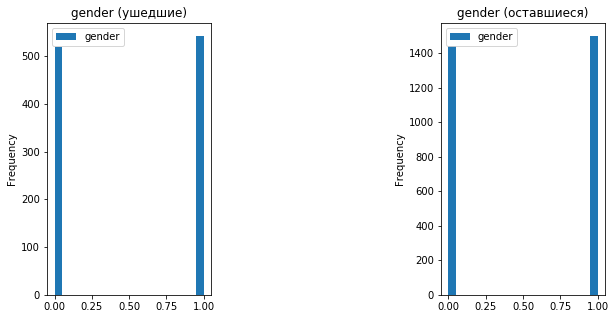

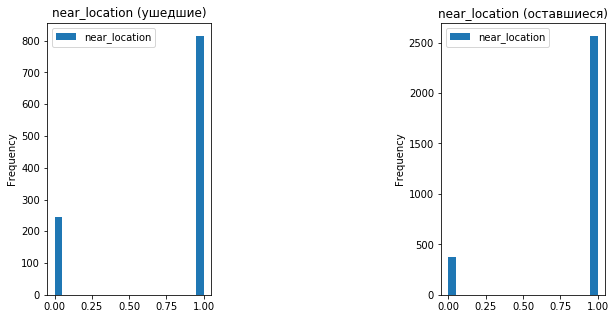

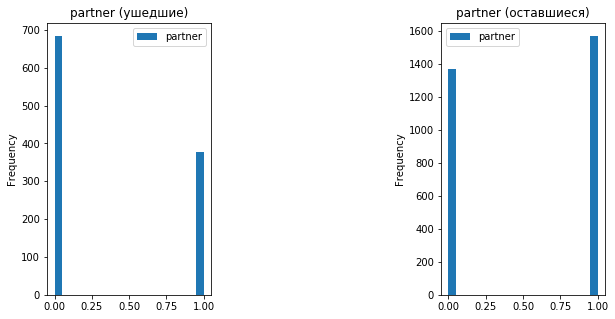

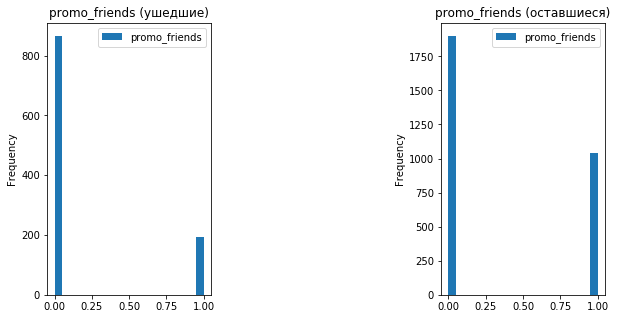

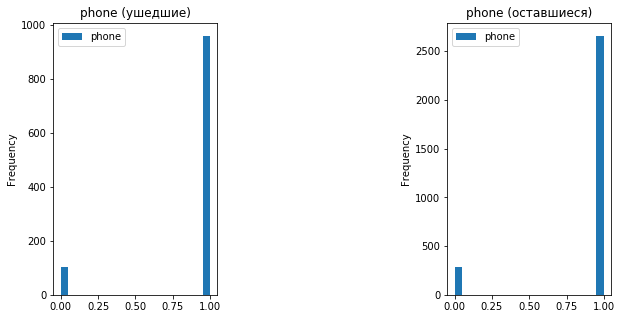

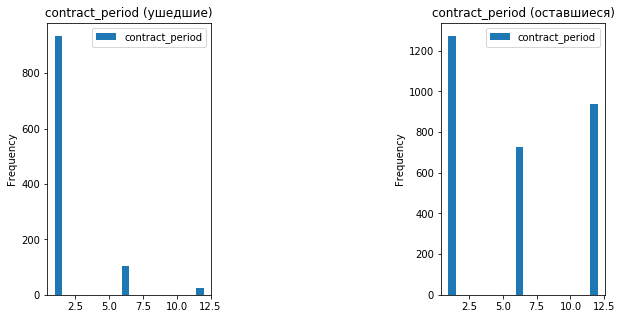

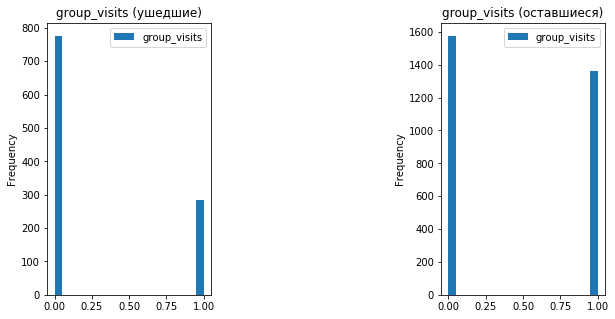

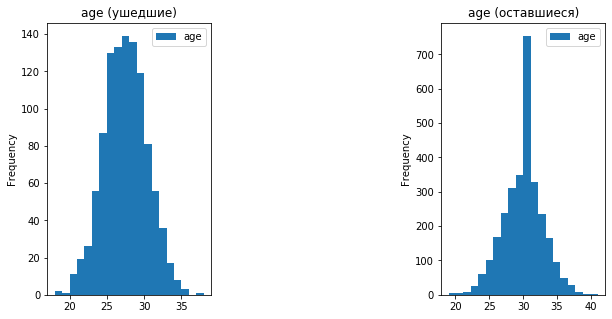

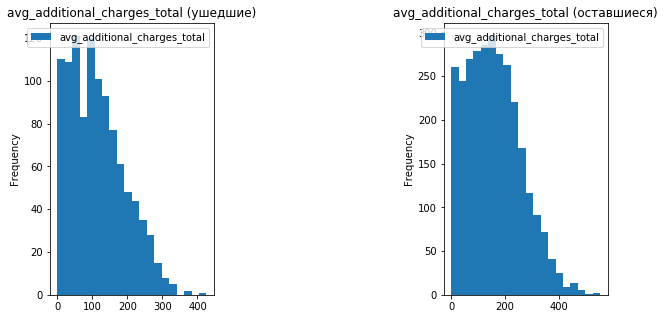

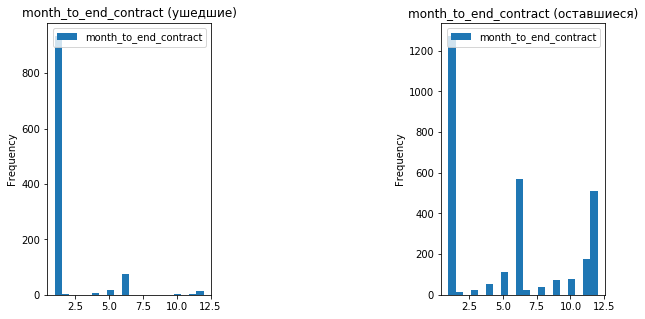

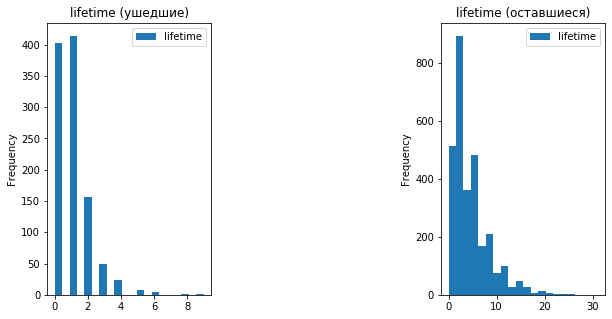

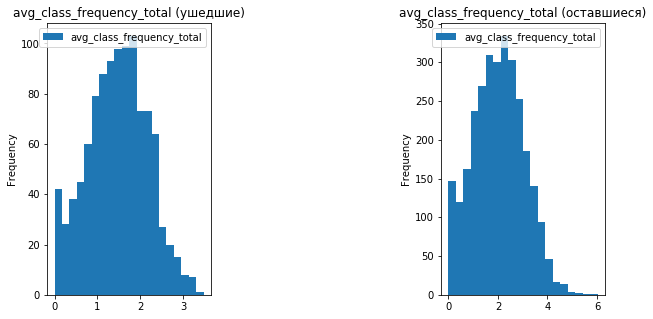

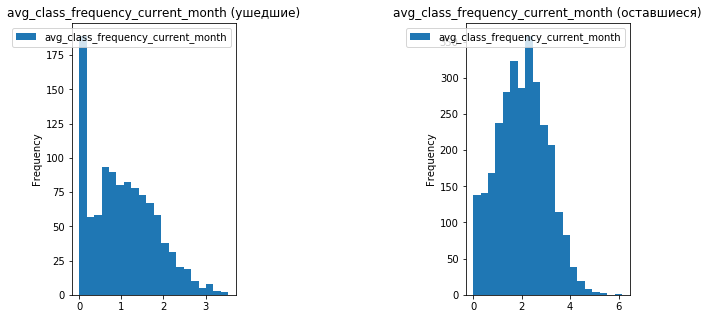

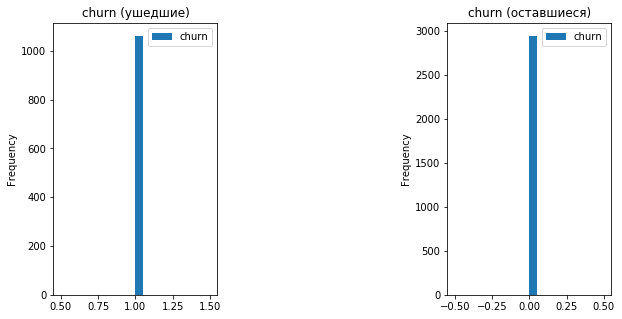

In [10]:
# Построим гистограммы

for i,j in zip(fitness_leave.columns, fitness_stay.columns):
    plt.subplot(1, 3, 1)
    fitness_leave[i].plot(kind='hist',
                          bins=20, figsize=(10,5),
                          title=str(i) + ' (ушедшие)',
                          legend = True)
    plt.subplot(1, 3, 3)
    fitness_stay[j].plot(kind='hist',
                         bins=20, figsize=(10,5),
                         title=str(j) + ' (оставшиеся)',
                         legend = True)
    plt.show()

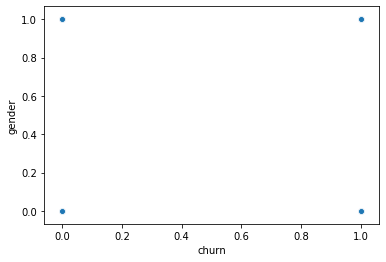

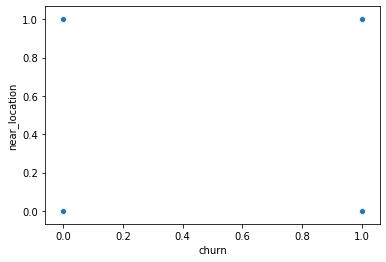

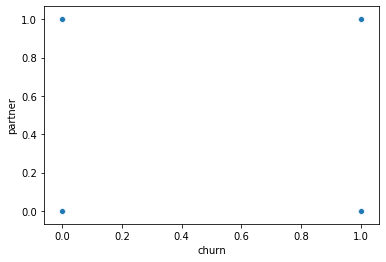

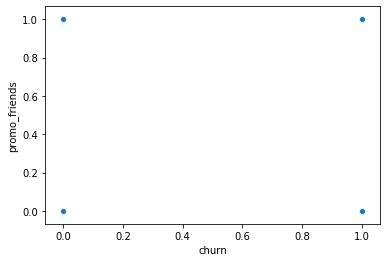

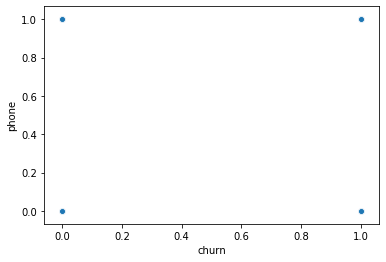

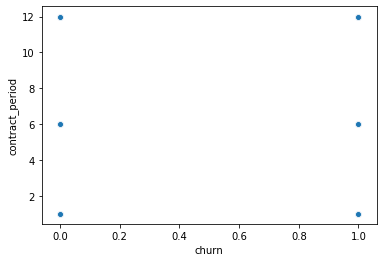

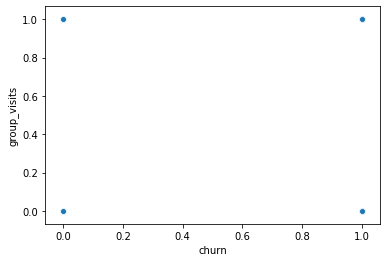

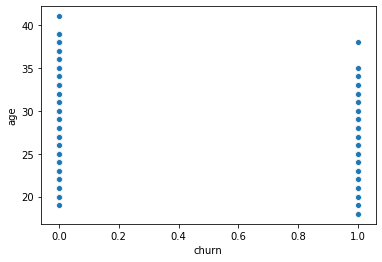

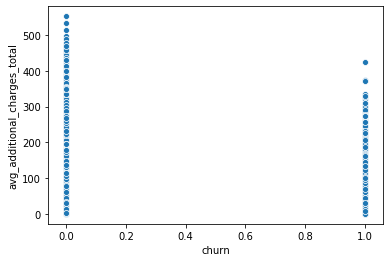

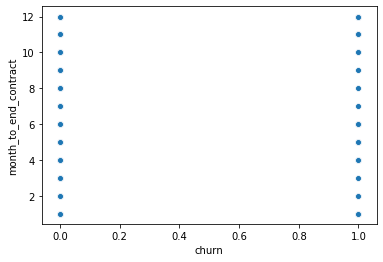

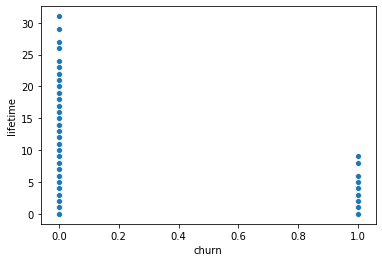

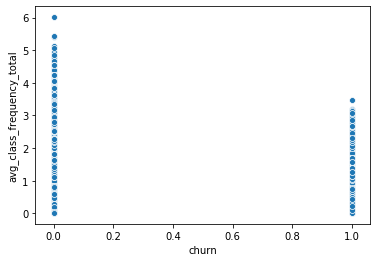

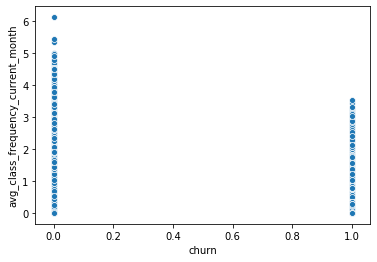

In [11]:
# Построим диаграммы рассеяния

for i in fitness.drop('churn', axis=1).columns:
    sns.scatterplot(x='churn', y=i, data=fitness)
    plt.show()

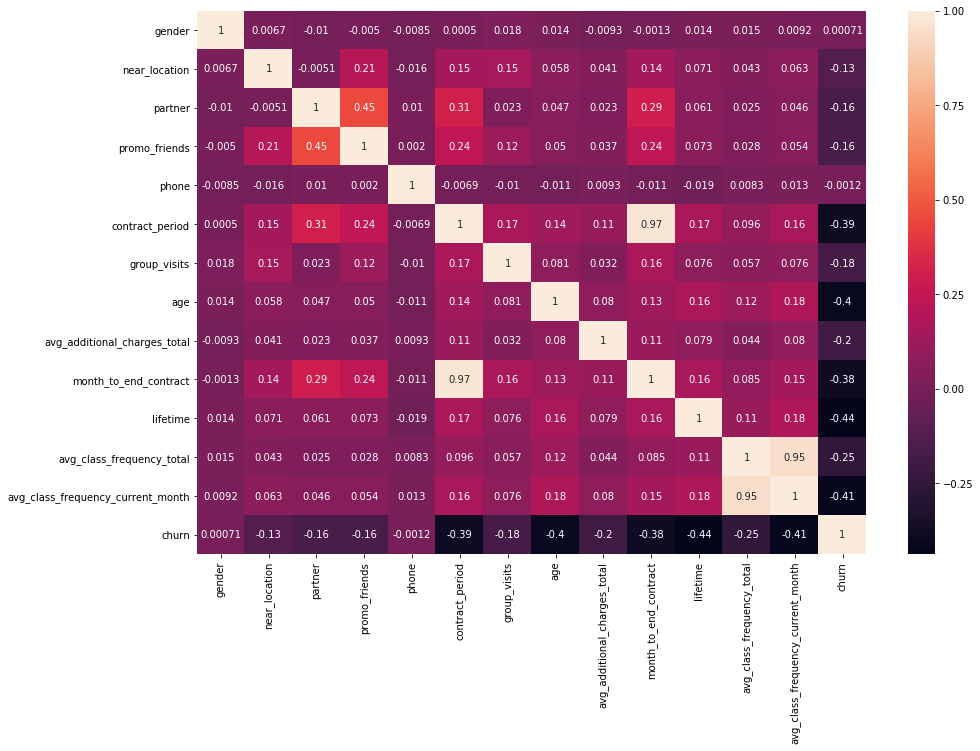

In [12]:
# Построим матрицу корреляци

fitness_corr = fitness.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(fitness_corr, annot=True)
plt.show()

### Вывод

- Пропусков в датасете нет. Все признаки количественные, поэтому преобразование категориальных признаков не требуется.
- Среднестатистический пользователь фитнес-центра - это мужчина или женщина (с примерно одинаковой вероятностью) преимущественно живущий или работающий рядом с залом, предоставивший свой номер телефона, купивший абонемент на 4,5 месяца без совета друга, возрастом около 29 лет,  посещающий клуб примерно 2 раза в неделю, суммарно купивший доп. услуг на 146 у.е., абонемент его заканчивается приблизительно через 4 месяца, и он скорее всего не уйдет из фитнесс-центра в следующем месяце.
- Среди ушедших и оставшихся пользователей примерно одинаковое кол-во мужчин и женщин, они жувут или работают преимущественно рядом с фитнесс-центром, а также предоставили свой номер телефона. Однако, ушедшие пользователи в меньшей доле пришли по партнерской программе, нежели оставшиеся; длительность абонемента ушедших с среднем существенно меньше, чем у оставшихся (5.7 против 1.7); ушедшие пользователи почти в 2 раза реже посещали групповые занятия; средний возраст ушедших пользователей на 3 года меньше, чем у оставшихся (27 лет против 30); ушедшие пользователи несколько меньше покупали доп. услуги фитнесс-центра; абонемент у ушедших заканчивается гораздо раньше, чем у оставшихся (5.2 месяца, против 1.6); ушедшие пользователи в среднем познакомились с фитнес-цетром только месяц назад (такой перекос скорее всего из-за большого кол-ва абонементов на месяц), тогда как оставшиеся в среднем 4.7 месяца назад; за прошедший месяц ушедшие пользователи ходили в фитнесс в 2 раза реже, нежели оставшиеся.
- Сильной корреляции признаков с целевой переменной не наблюдается. Она отрицательно коррелирует с длительностью абонемента, возрастом, кол-вом месяцев до окончания абонемента, продолжительностью знакомства пользователя с фитнесс-центром и частотой посещения клуба за последний месяц (чем больше значения данных признаков, тем меньше шансов, что пользователь уйдет). Также сильно коррелируют между собой признаки avg_class_frequency_total и avg_class_frequency_current_month, а также contract_period и month_to_end_contract, что в целом не удивительно.

## <a id="step3">Шаг 3. Построение модели прогнозирования оттока пользователей</a>

In [13]:
# Удалим коррелирующие один из коррелирующих между собой признаков

fitness_new = fitness.drop(['month_to_end_contract','avg_class_frequency_current_month'], axis = 1)

In [48]:
# Выделем целевую переменную и матрицу признаков

X = fitness_new.drop('churn', axis = 1)
y = fitness_new['churn']

In [15]:
# Разделим данные на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)


In [16]:
# Стандиртизируем обучающую и тестовую выборки

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)


In [17]:
# Зададим функцию, которая принимает на вход модель и данные и выводит метрики

models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]

def classification(m):
    
    # Задаем модель и обучаем ее
    
    model = m
    model.fit(X_train_st, y_train)
    
    # Делаем прогноз
    
    predictions = model.predict(X_test_st)
    probabilities = model.predict_proba(X_test_st)[:,1]
    
    # Выводим метрики
    
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

In [18]:
# Делаем прогноз и выводим метрики для логистической регрессии и случайного леса

for i in models:
    print(i)
    classification(i)
    print()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.91
Precision: 0.83
Recall: 0.83
F1: 0.83

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Accuracy: 0.89
Precision: 0.82
Recall: 0.73
F1: 0.77



### Вывод

Влиянием соседних наблюдений друг на друга мы пренебрегаем, поэтому мы использовали случайное разбиение матрицы признаков на обучающую и валидационную в соотношении 80 на 20. И алгоритм логистической регрессии, и случайный лес показали примерно одинаково высокие метрики (небольшое преимущество у регрессии): 
- Доля правильных ответов (метрика Accuracy) у логистической регрессии 91%, а у случайного леса 89%, однако полностью оценивать качество модели на основе данной метрики некорректно, так как она чуствительна к дисбалансу классов, а в нашем случае нельзя сказать, что классы сбалансированны (соотношение 3:1).
- Точность (метрика Precision) моделей практически идентична (83% и 82%), они одинаково точно предсказывают факт ухода пользователя.
- Полнота (метрика Recall) модели линейной регресси (83%) больше, чем у случайного леса (73%), что говорит о том, что регрессия лучше находит ушедших пользователей, нежели лес.
- Сбалансированная метрика между точностью и полнотой модели - F1-score, также выше у линейной регрессии.

## <a id="step4">Шаг 4. Кластеризация пользователей</a>

In [49]:
# Стандартизируем все признаки

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [50]:
df_new = pd.DataFrame(data = X_sc, columns=X.columns)
df_new

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,cluster_km
0,0.979706,0.427881,1.026861,1.497161,-3.059852,0.289890,1.194032,-0.056554,-1.377531,0.161605,-0.193329,-1.911920,-1.678472,2.157824
1,-1.020715,0.427881,-0.973842,-0.667931,0.326813,1.608822,1.194032,0.557327,-0.350213,1.831941,0.873680,0.045176,0.136014,-0.897142
2,-1.020715,0.427881,1.026861,-0.667931,0.326813,-0.809219,-0.837498,-0.363494,-0.181592,-0.792873,-0.460081,-0.020493,-0.029019,-0.897142
3,-1.020715,0.427881,1.026861,1.497161,0.326813,1.608822,1.194032,1.171208,-0.874722,1.831941,-0.460081,1.364655,1.510450,0.121180
4,0.979706,0.427881,1.026861,1.497161,0.326813,-0.809219,-0.837498,-0.977375,0.533700,-0.792873,-0.193329,-0.787076,-0.614542,0.121180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.979706,0.427881,1.026861,-0.667931,0.326813,1.608822,-0.837498,1.171208,-1.500232,1.831941,1.140432,0.417105,0.552842,0.121180
3996,-1.020715,0.427881,-0.973842,-0.667931,0.326813,-0.809219,1.194032,-0.056554,-0.810225,-0.792873,-0.726833,-0.619110,-1.400294,-0.897142
3997,0.979706,0.427881,1.026861,1.497161,0.326813,1.608822,-0.837498,-0.363494,-0.713002,1.593322,-0.460081,0.933139,1.011031,0.121180
3998,-1.020715,0.427881,1.026861,1.497161,0.326813,0.289890,-0.837498,0.864268,-0.882582,0.161605,-0.193329,-0.256049,-0.162252,0.121180


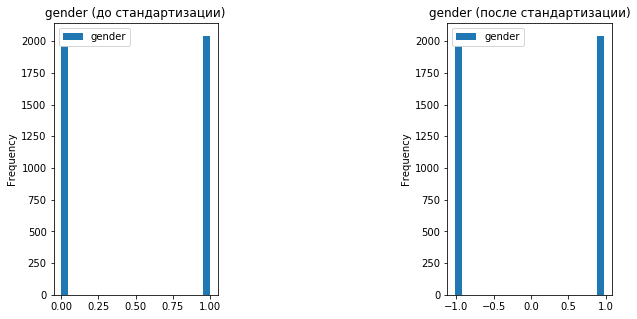

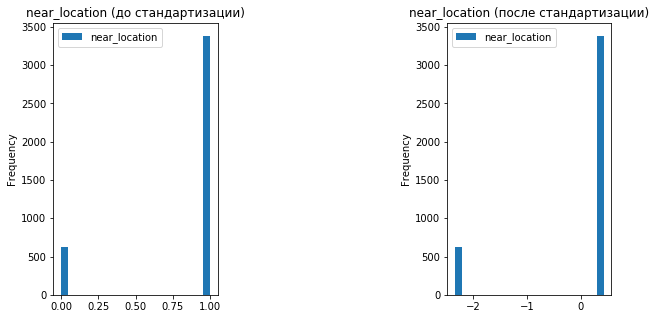

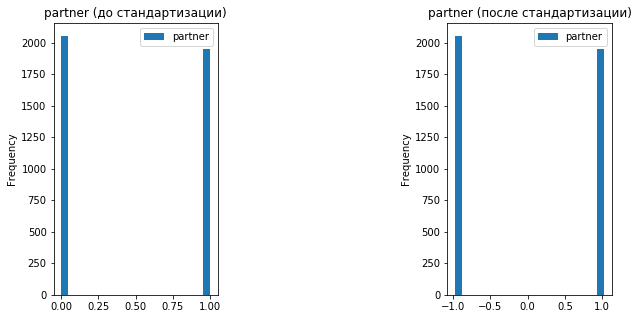

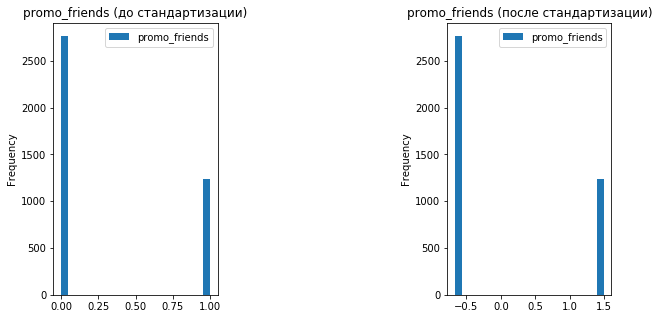

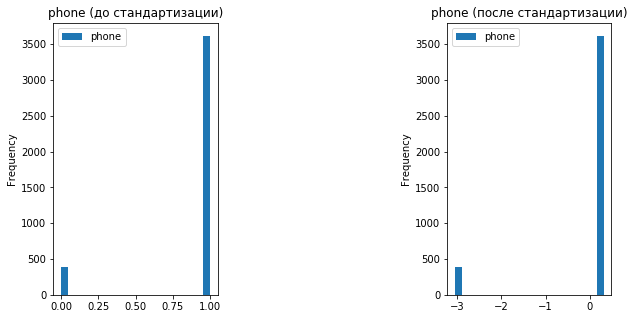

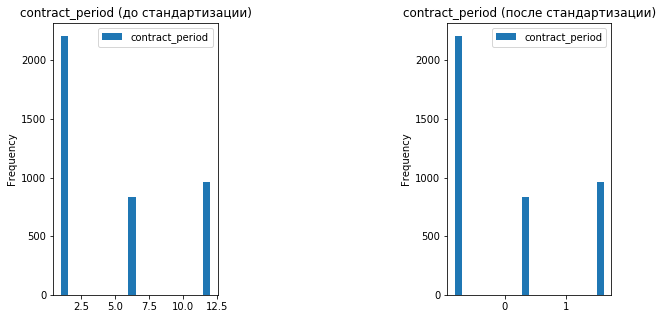

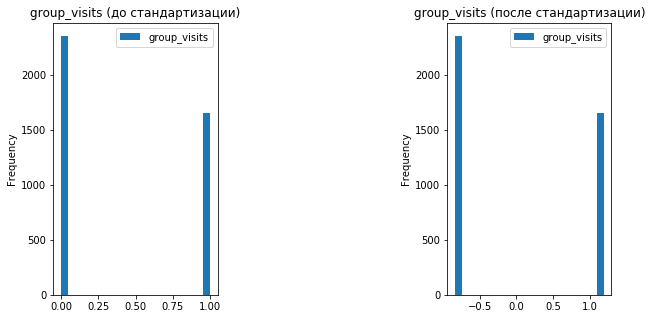

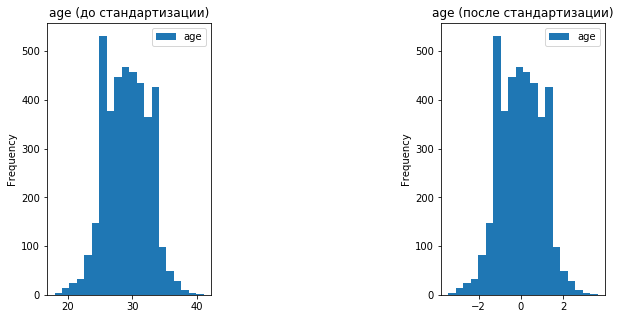

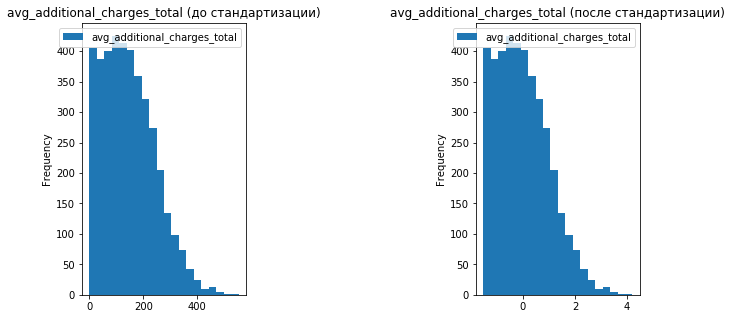

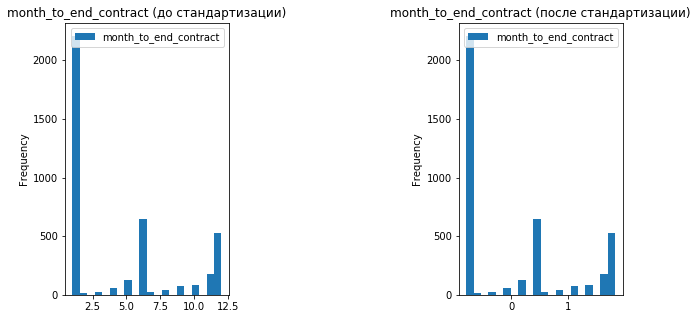

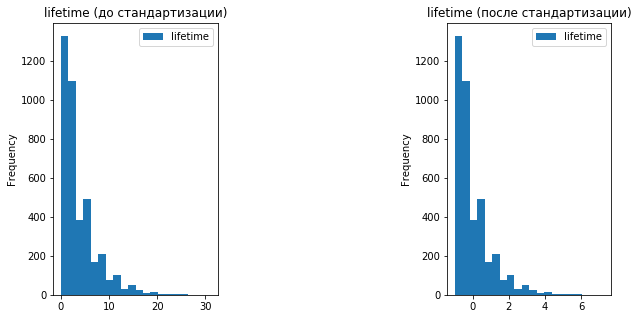

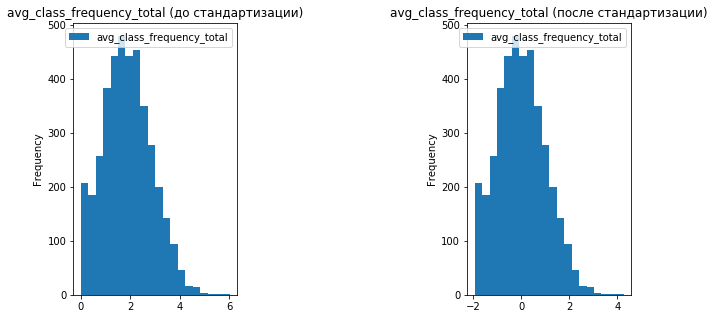

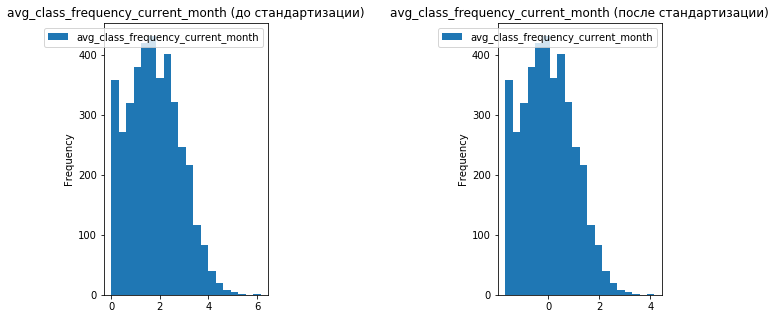

In [58]:
for i,j in zip(fitness.drop(['churn', 'cluster_km'], axis=1).columns, df_new.drop(['cluster_km'], axis=1).columns):
    plt.subplot(1, 3, 1)
    fitness[i].plot(kind='hist',
                          bins=20, figsize=(10,5),
                          title=str(i) + ' (до стандартизации)',
                          legend = True)
    plt.subplot(1, 3, 3)
    df_new[j].plot(kind='hist',
                         bins=20, figsize=(10,5),
                         title=str(j) + ' (после стандартизации)',
                         legend = True)
    plt.show()

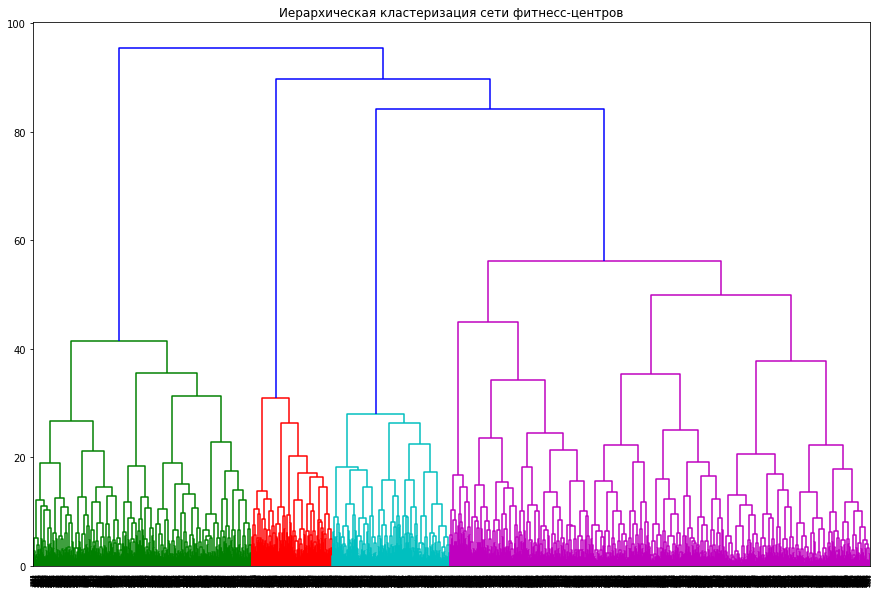

In [22]:
# Построим матрицу расстояний

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация сети фитнесс-центров')
plt.show()

In [30]:
# Применим модель кластеризации на основе алгоритма K-Means (число кластеров = 4)

km = KMeans(n_clusters = 4, random_state=0) 
labels = km.fit_predict(X_sc)
fitness['cluster_km'] = labels
X['cluster_km'] = labels

# Посмотрим на средние значения признаков для кластеров

X.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total
cluster_km,,,,,,,,,,,
0,0.524599,1.000000,0.176893,0.061913,1.0,3.035931,0.394140,28.974019,143.390526,3.334439,1.848948
1,0.490354,0.995981,0.941318,0.772508,1.0,7.787781,0.513666,29.663183,157.200280,4.524920,1.979426
2,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211


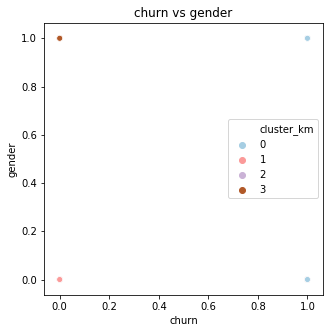

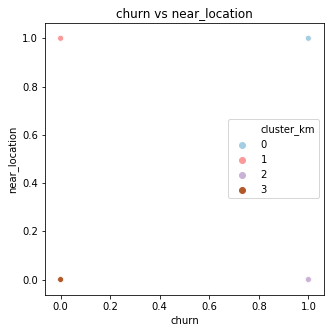

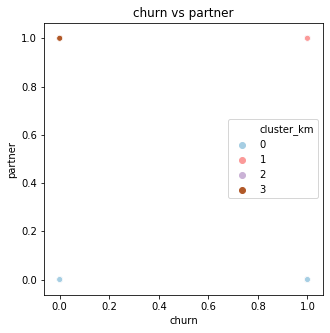

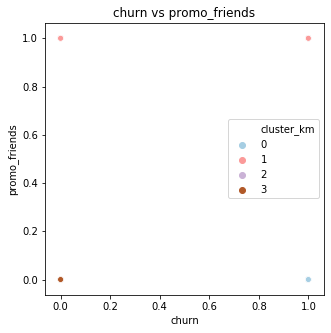

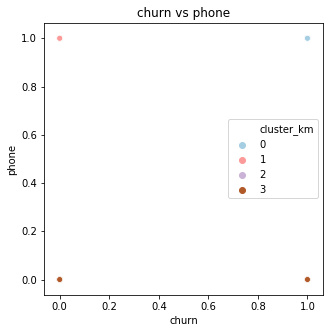

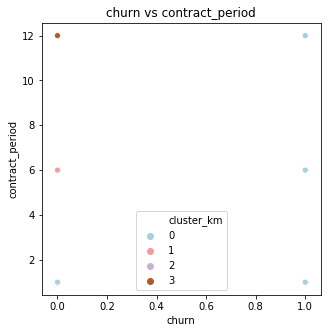

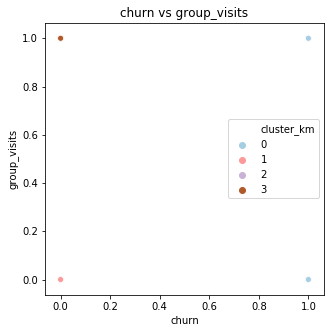

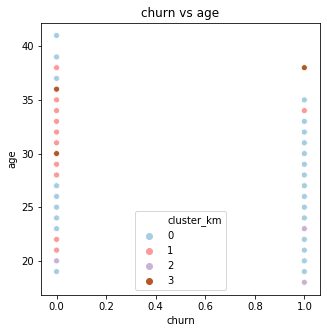

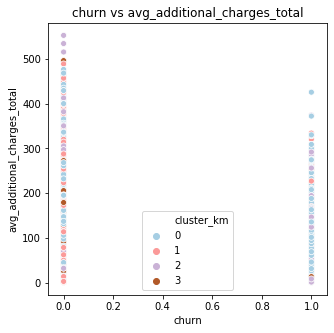

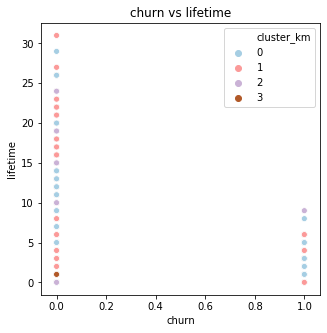

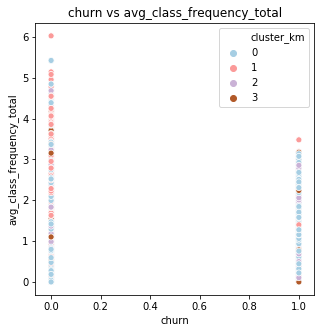

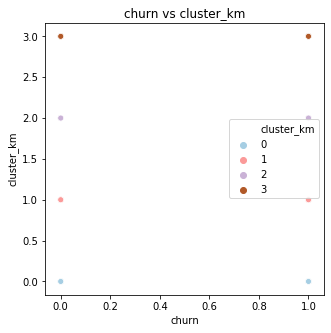

In [31]:
# Посмотрим на распределиние признаков для кластеров (scatterplot)

def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (5,5))
    sns.scatterplot(df[x_name], df[y_name],
           hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

for i in X.columns:
    show_clusters_on_plot(fitness, 'churn', i, 'cluster_km')

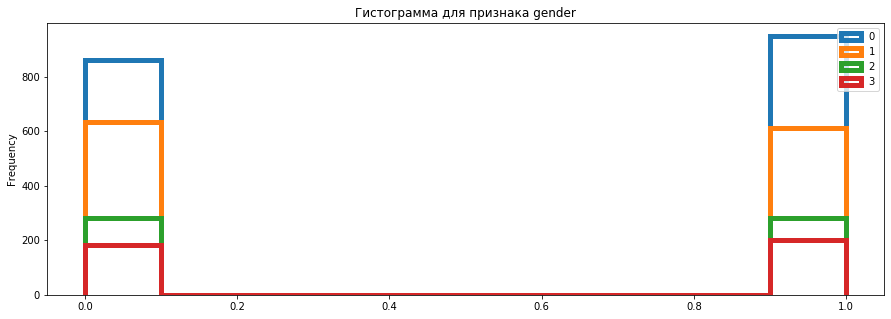

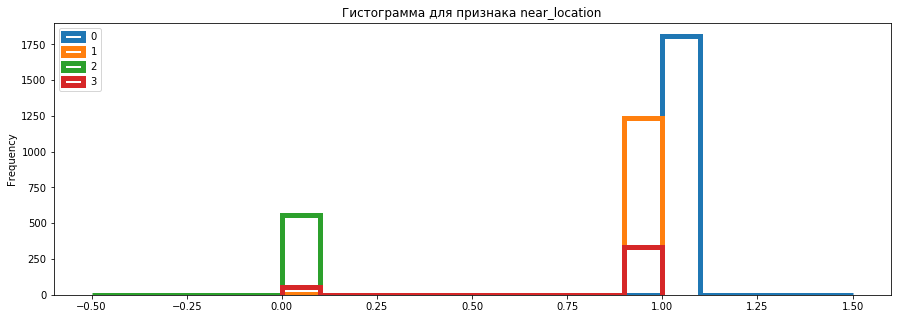

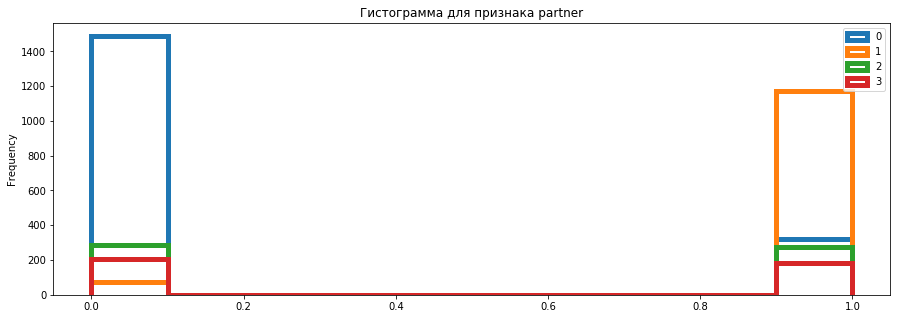

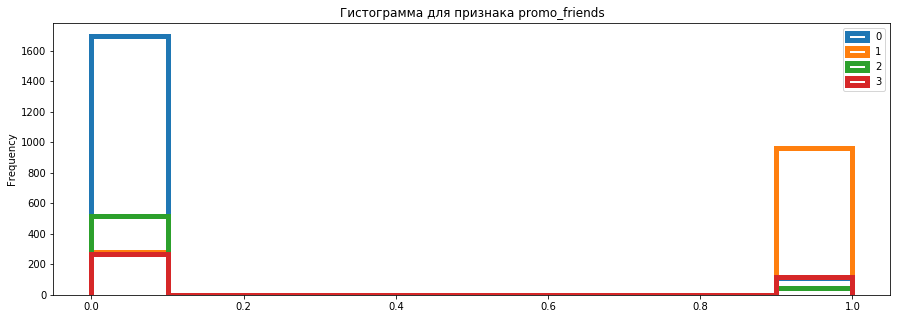

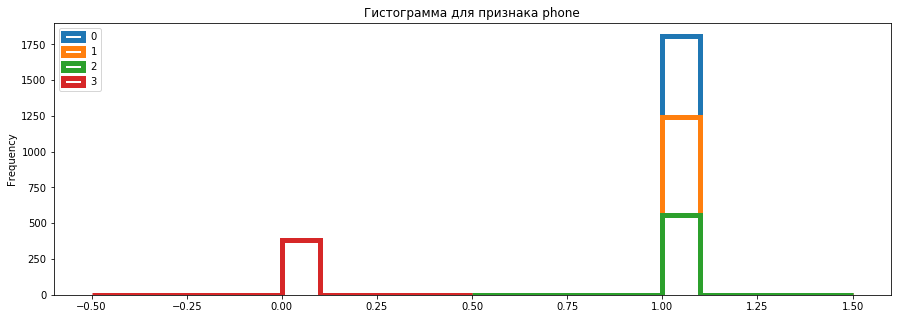

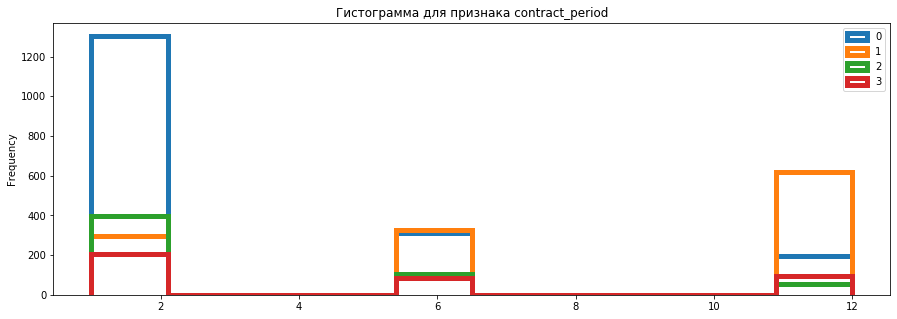

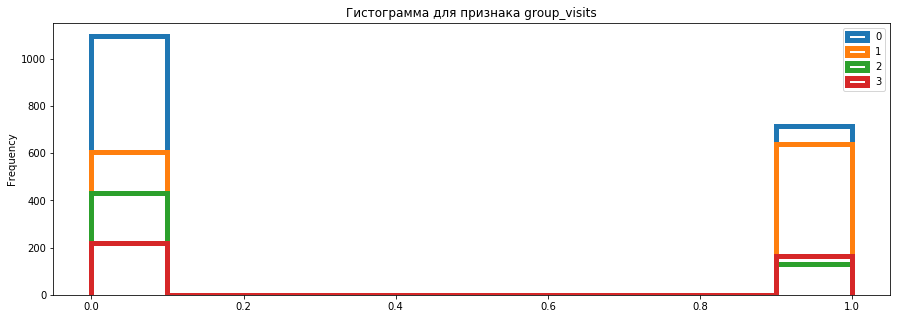

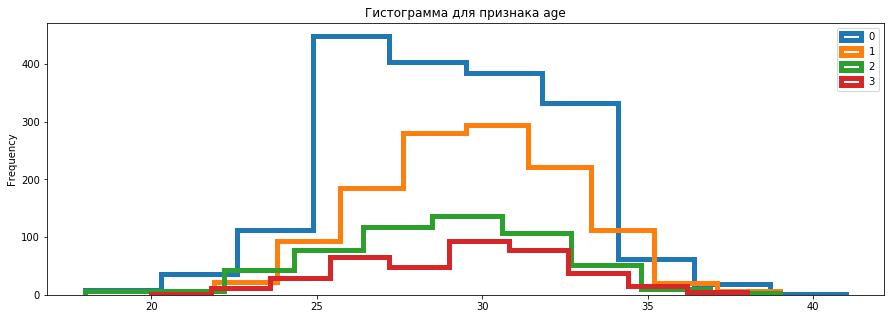

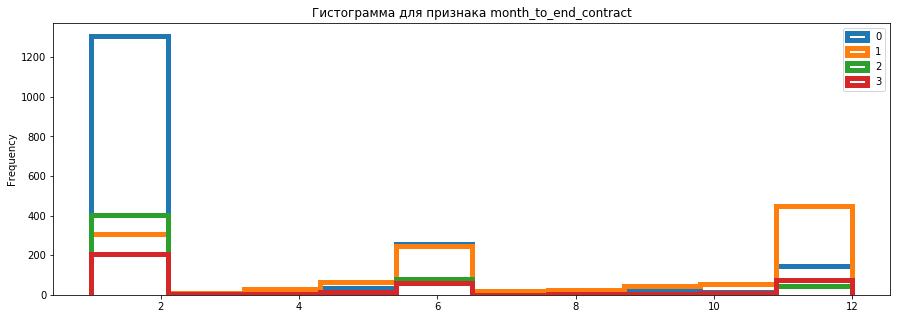

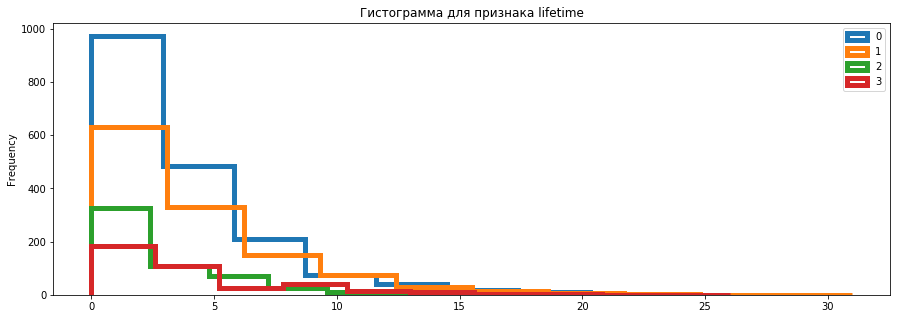

In [32]:
# Посмотрим на распределиние дискретных и логических признаков для кластеров (hist)

for i in (fitness.drop(['cluster_km', 
                        'churn', 
                        'avg_additional_charges_total', 
                        'avg_class_frequency_total',
                        'avg_class_frequency_current_month'], axis=1).columns):
    fitness.groupby('cluster_km')[i].plot(kind='hist',
                                          histtype='step',
                                          figsize=(15,5),
                                          title='Гистограмма для признака '+ str(i),
                                          legend = True,
                                          linewidth=5)
    plt.show()

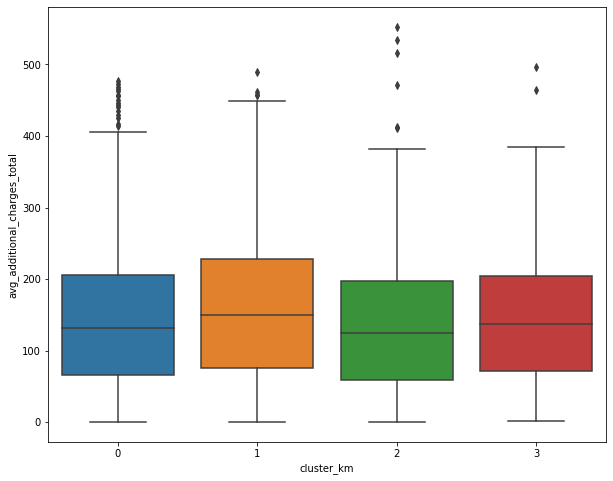

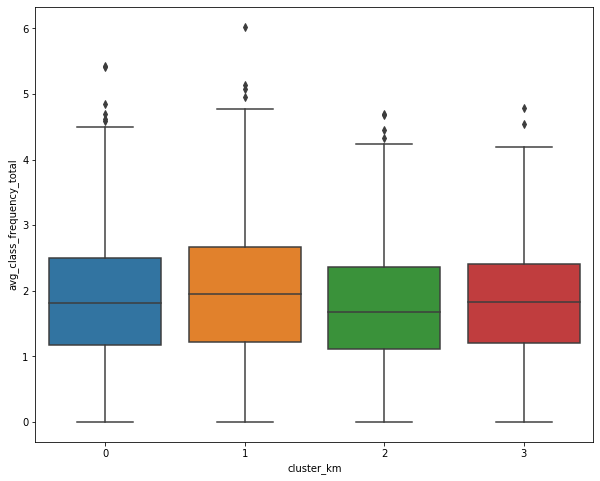

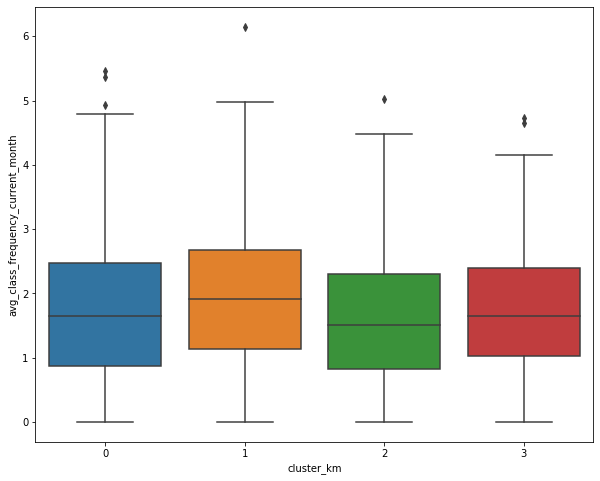

In [34]:
# Посмотрим на распределиние непрерывных признаков для кластеров (boxplot)

for i in ['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize=(10, 8))
    sns.boxplot(x='cluster_km', y=i, data=fitness)
    plt.show()

In [35]:
# Посчитаем долю оттока для каждого полученного кластера

fitness_total = fitness.groupby('cluster_km')['churn'].agg('count').reset_index().rename(columns={'churn':'total'})
fitness_churn = fitness.query('churn == 1').groupby('cluster_km')['churn'].agg('count').reset_index()
percentage = fitness_total.merge(fitness_churn, on='cluster_km')
percentage['percentage %'] = (percentage['churn'] / percentage['total'] * 100).round(1)
percentage

,cluster_km,total,churn,percentage %
0,0,1809,602,33.3
1,1,1244,132,10.6
2,2,561,224,39.9
3,3,386,103,26.7


### Вывод

- В соответствии с дендрограммой можно выделить 4 кластера.

- Алгоритмом K-Means пользователи были разбиты на 4 кластеров. В соответствии со средними значениями признаков можно выделить группу №1. В ней выделяется достаточно большое значение признаков contract_period и month_to_end_contract, по которым можно предположить, что в данной группе будет наименьший % оттока пользователей.

- Гистограммы признаков показывают, что алгоритм включил в группу №3 пользователей без телефона; пользователи из группы №1 чаще приводили пользователей, чем пользователи остальных групп; в группе №2 находятся пользователи, которые не живут или работают рядом с фитнесс-центром; в группе №0 пребладают более молодые(до 30 лет) пользователи; пользователей с наибольшим кол-во месяцев до истечения договора в группе №1, а с наименьшим в группе №0; также выделим, что в группе №1 больше больше пользователей, которые пользовались другими услугами фитнесс-центра. Остальные признаки распределены по группам равномерно.

- Данные по доле оттока подтвердили наши предположения, о том что в группе №1 наименьший отток пользователей, а наибольший отток наблюдается в группах №0 и №2.

## <a id="step5">Шаг 5. Выводы и рекомендации</a>

Исходя из построенной модели кластеризации можно сделать следующие выводы и рекомендации:

1. Пользователи, приобретающие долгосрочные абонементы, более лояльны к финтнесс-центру, их проще удержать. Стоит сделать акцент на продвижении именно таких абонементов.
2. Местоположение фитнесс-центра рядом с домом или работой также оказывает влияние на решения пользователя остаться или уйти. Возможно, оффлайн реклама в радиусе 1 км от фитнесс-центра или таргетированная рекламная рассылка с привязкой к местоположению пользователя будет иметь успех.
3. Пользователи моложе 30 лет более склонные к уходу. Возможно, стоит проработать более современные программы тренировок, которые могли бы заинтересовать молодое поколение, или сменить формат фитнесс-центра на более актуальный и свежий.
4. Покупка дополнительных услуг фитнесс-центра также влияет на лояльность пользователей. Стоит развивать направление сопутствующих услуг, главное не переборщить.